In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Read data
df = pd.read_csv('only_pfs.csv')

df = df.fillna(0)
print(df.columns)

Index(['page_id', 'timestamp_ns', 'is_write', 'distance', 'pid', 'fault_flags',
       'vm_flags', 'fault_count', 'vma_start', 'vma_end',
       'time_since_last_fault', 'offset_in_vma', 'vma_size',
       'relative_position', 'sequential_access'],
      dtype='object')


In [20]:
def create_ml_dataset(data, window_size=3):
    df = data
    features = []
    targets = []

    for i in range(window_size, len(df)):
        # Get window k faults
        window = df.iloc[i-window_size:i]
        next_fault = df.iloc[i]  # Predict (k+1)

        # Create a feature vector by concatenating all window data
        window_data = []
        for _, row in window.iterrows():
            window_data.extend([
                row['timestamp_ns'],
                row['page_id'],
                row['is_write'],
                row['distance'],
                # row['pid'],
                # row['fault_flags'],
                row['vm_flags'],
                # row['fault_count'],
                row['vma_start'],
                # row['vma_end'],
                row['time_since_last_fault'],
                # row['offset_in_vma'],
                row['vma_size'],
                row['relative_position'],
                row['sequential_access'],
            ])

        features.append(window_data)
        targets.append(next_fault['timestamp_ns'])  # Only predicting the next timestamp

    return pd.DataFrame(features), pd.Series(targets, name='next_timestamp')

In [4]:
X, Y = create_ml_dataset(df, window_size=3)
X = X.to_numpy()
Y = Y.to_numpy()
print('Shape of X and Y:')
print(X.shape)
print(Y.shape)
# Split and scale
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

Shape of X and Y:
(997, 30)
(997,)


In [18]:
def evaluate(dataframe):
  X, Y = create_ml_dataset(dataframe, window_size=3)
  X = X.to_numpy()
  Y = Y.to_numpy()
  print('Shape of X and Y:')
  print(X.shape)
  print(Y.shape)
  # Split
  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

  # Baseline model
  y_pred_baseline = np.full_like(y_test, y_train.mean())
  baseline_mse = mean_squared_error(y_test, y_pred_baseline)
  baseline_rmse = np.sqrt(baseline_mse)
  print("\nBaseline (Mean) Results:")
  print(f"RMSE: {baseline_rmse:.2f} ns")

  # ML models
  models = {
      'Linear Regression': LinearRegression(),
      'Ridge': Ridge(alpha=1.0),
      'Lasso': Lasso(alpha=1.0),
      'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
      'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
  }

  results = {}
  for name, model in models.items():
      model.fit(X_train, y_train) # Train
      y_pred = model.predict(X_test) # predict
      # y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

      mse = mean_squared_error(y_test, y_pred)
      rmse = np.sqrt(mse)

      # Calculate improvement over our baseline
      improvement = ((baseline_rmse - rmse) / baseline_rmse) * 100

      results[name] = {
          'RMSE': rmse,
          'Improvement': improvement,
          'Predictions': y_pred
      }
      print(f"\n{name} Results:")
      print(f"RMSE: {rmse:.2f} ns")
      print(f"Improvement over baseline: {improvement:.8f}%")

  plt.figure(figsize=(15, 10))

  models = list(results.keys())
  rmse_scores = [results[model]['RMSE'] for model in models]
  improvements = [results[model]['Improvement'] for model in models]

  # Relative improvements
  min_improvement = min(improvements)
  relative_improvements = [imp - min_improvement for imp in improvements]

  # RMSE scores
  ax1 = plt.gca()
  ax2 = ax1.twinx()

  x = np.arange(len(models))
  width = 0.35

  ax1.set_yscale('log')
  bars1 = ax1.bar(x - width/2, rmse_scores, width, label='RMSE (log scale)', color='skyblue')
  bars2 = ax2.bar(x + width/2, relative_improvements, width,
                  label='Relative Improvement %', color='lightgreen')

  ax1.axhline(y=baseline_rmse, color='red', linestyle='--', label='Baseline RMSE')

  ax1.set_xlabel('Models')
  ax1.set_ylabel('RMSE (ns) - Log Scale')
  ax2.set_ylabel('Relative Improvement (%)')
  plt.title('Model Performance Comparison')

  # Add values
  def add_value_labels(bars, ax, format_str='{:.2f}'):
      for bar in bars:
          height = bar.get_height()
          ax.text(bar.get_x() + bar.get_width()/2., height,
                  format_str.format(height),
                  ha='center', va='bottom')

  add_value_labels(bars1, ax1, '{:.2e}')
  add_value_labels(bars2, ax2, '+{:.3f}%')

  ax1.set_xticks(x)
  ax1.set_xticklabels(models, rotation=45)

  lines1, labels1 = ax1.get_legend_handles_labels()
  lines2, labels2 = ax2.get_legend_handles_labels()
  ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

  plt.tight_layout()
  plt.show()

Shape of X and Y:
(997, 30)
(997,)

Baseline (Mean) Results:
RMSE: 2908181957.89 ns

Linear Regression Results:
RMSE: 16106.35 ns
Improvement over baseline: 99.99944617%

Ridge Results:
RMSE: 17069.52 ns
Improvement over baseline: 99.99941305%

Lasso Results:
RMSE: 16241.31 ns
Improvement over baseline: 99.99944153%

Random Forest Results:
RMSE: 7123013.13 ns
Improvement over baseline: 99.75506989%

Gradient Boosting Results:
RMSE: 24019706.43 ns
Improvement over baseline: 99.17406453%


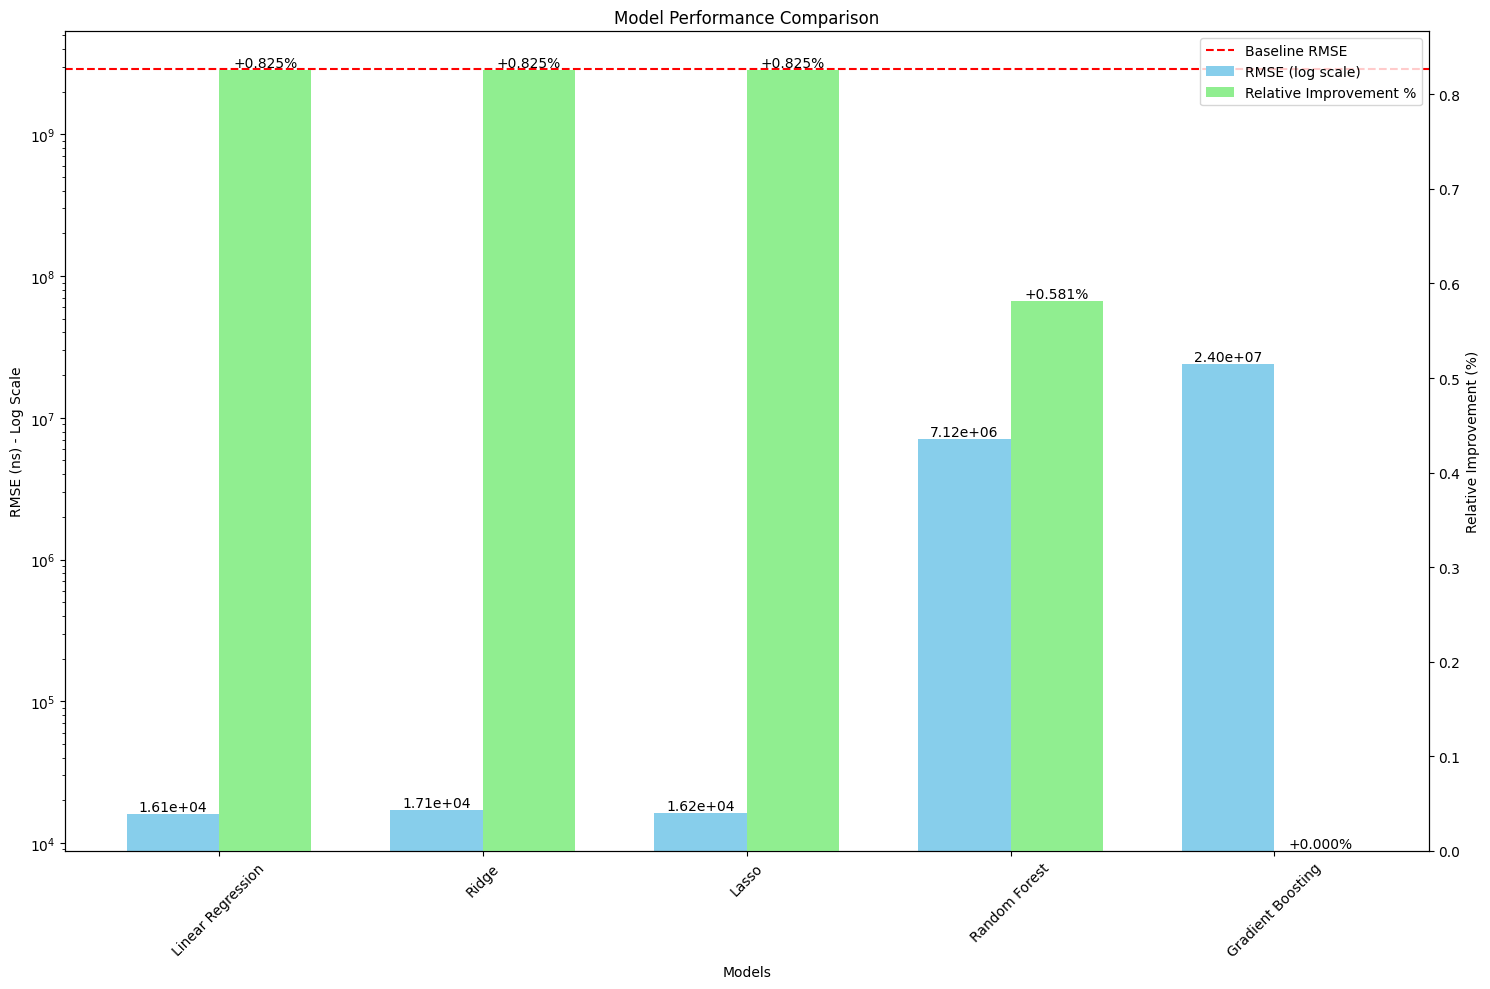


Detailed Performance Metrics:
Model                RMSE            Improvement     Relative Improvement
-----------------------------------------------------------------
Linear Regression    1.61e+04  99.999%      +0.825%
Ridge                1.71e+04  99.999%      +0.825%
Lasso                1.62e+04  99.999%      +0.825%
Random Forest        7.12e+06  99.755%      +0.581%
Gradient Boosting    2.40e+07  99.174%      +0.000%


In [14]:
evaluate(df)

Index(['page_id', 'timestamp_ns', 'is_write', 'distance', 'pid', 'fault_flags',
       'vm_flags', 'fault_count', 'vma_start', 'vma_end',
       'time_since_last_fault', 'offset_in_vma', 'vma_size',
       'relative_position', 'sequential_access'],
      dtype='object')
(2003, 15)
Shape of X and Y:
(2000, 30)
(2000,)

Baseline (Mean) Results:
RMSE: 18399740396.45 ns

Linear Regression Results:
RMSE: 7575932.73 ns
Improvement over baseline: 99.95882587%

Ridge Results:
RMSE: 7572834.23 ns
Improvement over baseline: 99.95884271%

Lasso Results:
RMSE: 8395055.22 ns
Improvement over baseline: 99.95437406%


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.09745e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T



Random Forest Results:
RMSE: 29101881.14 ns
Improvement over baseline: 99.84183537%

Gradient Boosting Results:
RMSE: 142188863.85 ns
Improvement over baseline: 99.22722353%


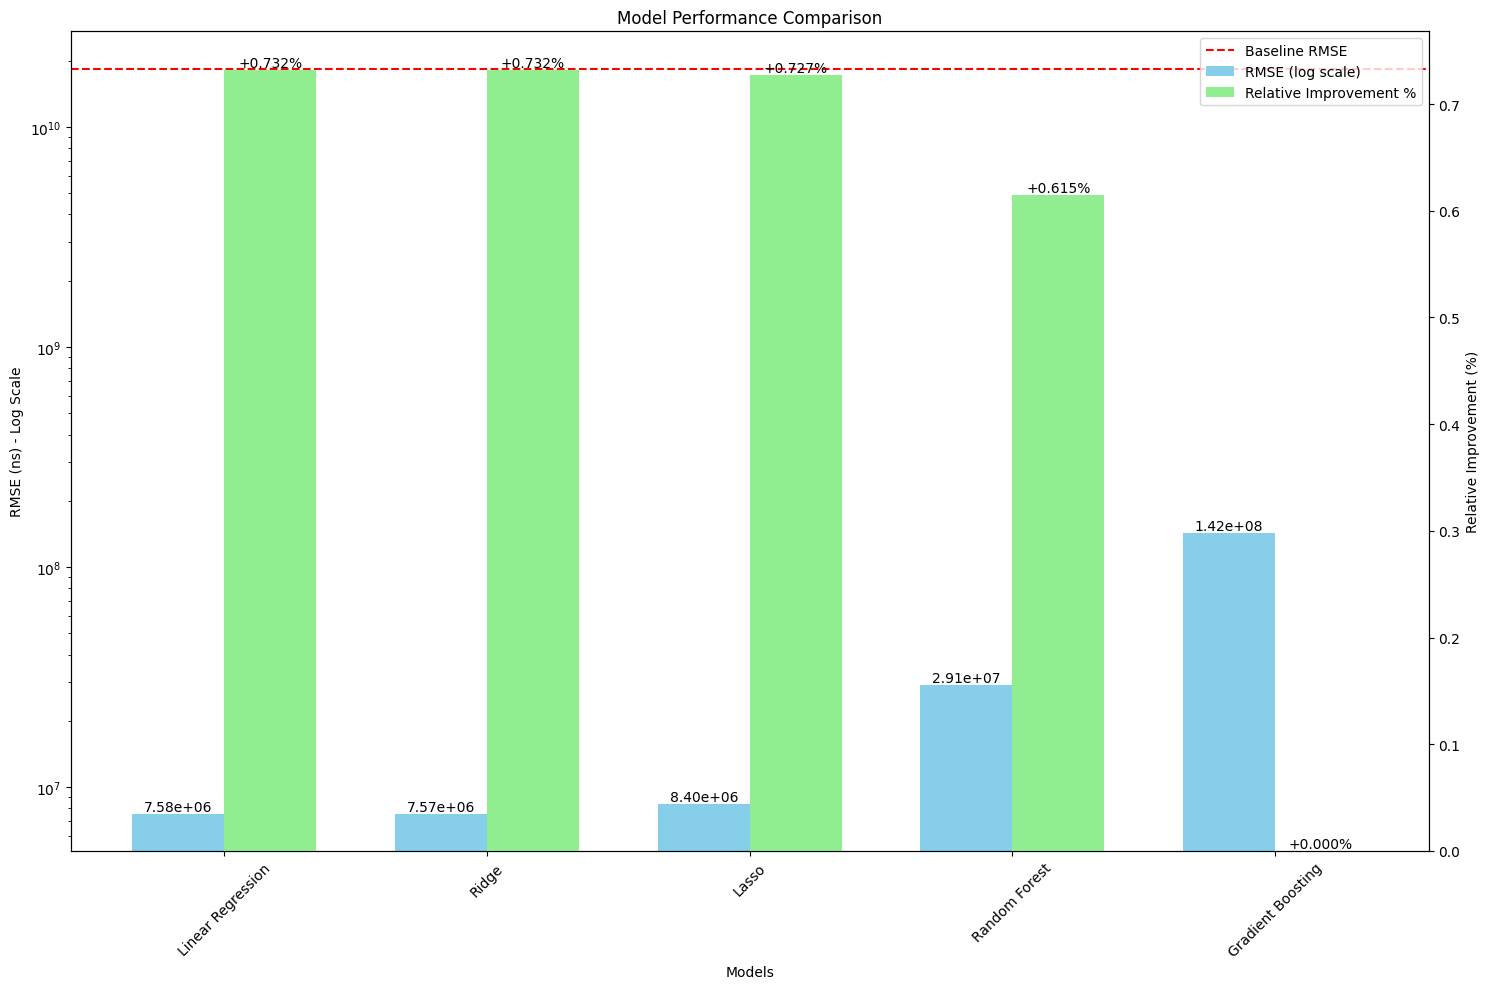

In [24]:
# Read data
df_2 = pd.read_csv('only_pfs2.csv')

df_2 = df_2.fillna(0)
print(df_2.columns)
print(df_2.shape)

evaluate(df_2)

Index(['page_id', 'timestamp_ns', 'is_write', 'distance', 'pid', 'fault_flags',
       'vm_flags', 'fault_count', 'vma_start', 'vma_end',
       'time_since_last_fault', 'offset_in_vma', 'vma_size',
       'relative_position', 'sequential_access'],
      dtype='object')
(5000, 15)
Shape of X and Y:
(4997, 30)
(4997,)

Baseline (Mean) Results:
RMSE: 18553207930.72 ns

Linear Regression Results:
RMSE: 12697585.05 ns
Improvement over baseline: 99.93156124%

Ridge Results:
RMSE: 12697629.37 ns
Improvement over baseline: 99.93156100%

Lasso Results:
RMSE: 12699605.16 ns
Improvement over baseline: 99.93155035%


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.53525e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T



Random Forest Results:
RMSE: 14230599.52 ns
Improvement over baseline: 99.92329844%

Gradient Boosting Results:
RMSE: 130181029.12 ns
Improvement over baseline: 99.29833682%


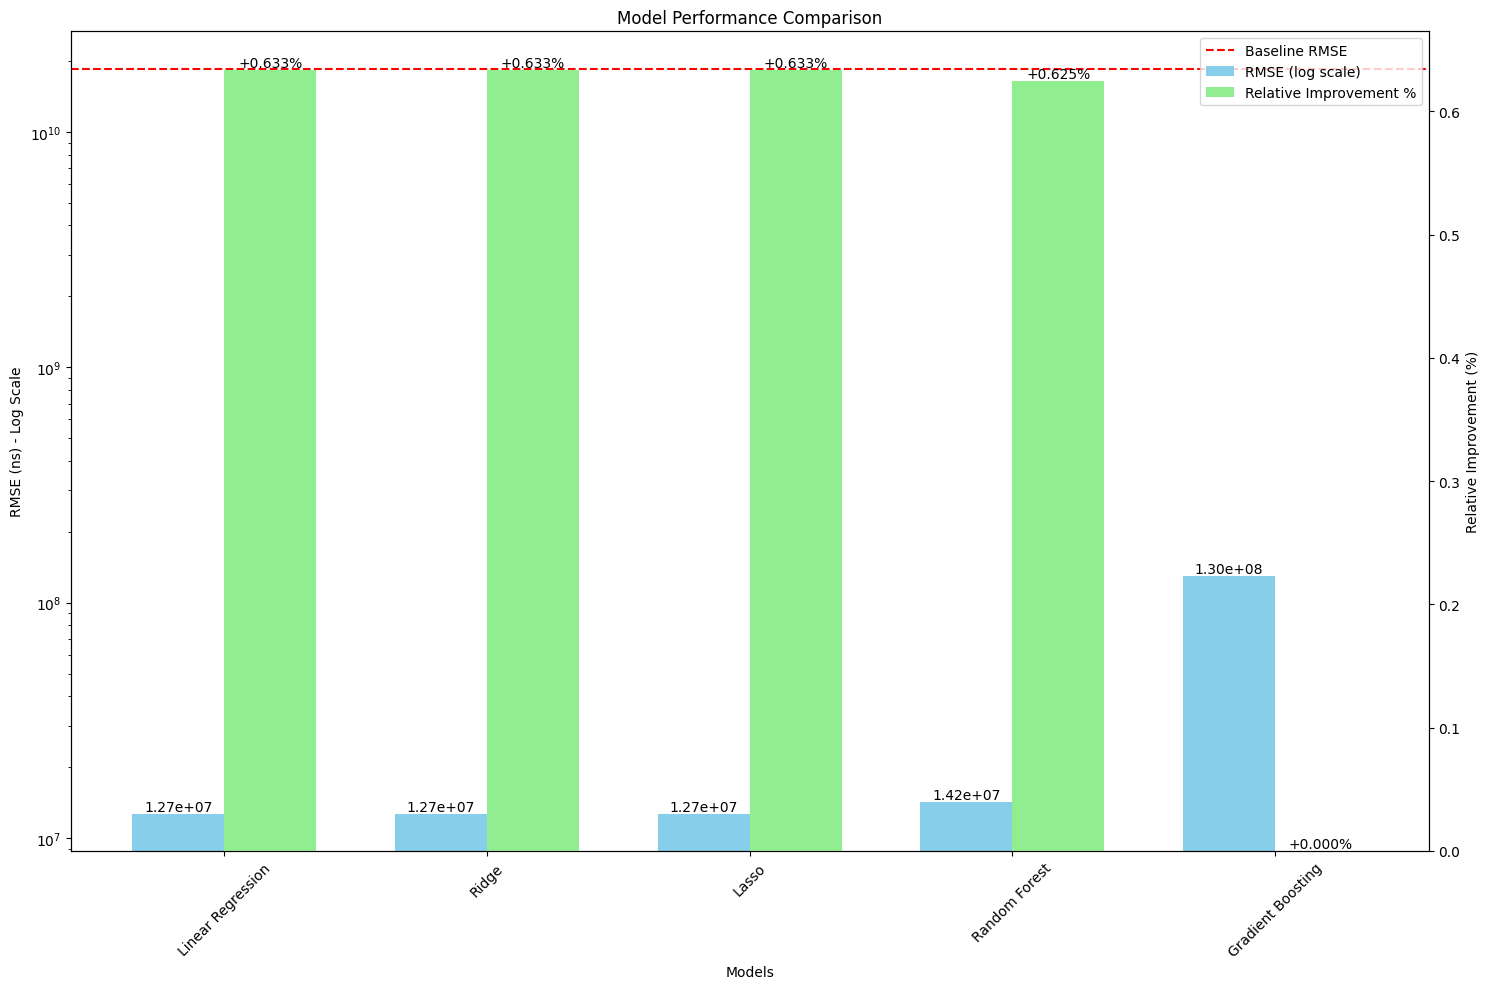

In [25]:
# Read data
df_3 = pd.read_csv('only_pfs3.csv')

df_3 = df_3.fillna(0)
print(df_3.columns)
print(df_3.shape)

evaluate(df_3)